In [1]:
from data.pose_tracker import pose_tracker
from common.model import TemporalModel
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import argparse
import torch
import tqdm
import os

In [2]:
input_files = "/home/kjakkala/Datasets/nturgb+d_rgb_2d_skeletons/*.npz"
output_dir = "/home/kjakkala/Datasets/nturgb+d_rgb_3d_skeletons/"
chk_filename = 'checkpoint/pretrained_h36m_detectron_coco.bin'

In [3]:
kps_left = [1, 3, 5, 7, 9, 11, 13, 15]
kps_right = [2, 4, 6, 8, 10, 12, 14, 16]
joints_left = [4, 5, 6, 11, 12, 13]
joints_right = [1, 2, 3, 14, 15, 16]

In [4]:
def decode(filename):
    data = np.load(filename, allow_pickle=True)
    keypoints = data['keypoints']
    tracker = pose_tracker(data_frame=len(keypoints), num_joint=17)
    for i, frame in enumerate(keypoints):
        if len(frame.shape) != 3:
            print('file has empty skeleton_sequence', filename)
            return
        tracker.update(frame, i+1)
    skeletons = tracker.get_skeleton_sequence()[:, :, :, :2]
    skeletons[..., :2] = skeletons[..., :2]/1920.0*2 - [1, 0.5625]    
    skeletons= np.pad(skeletons, ((0, 0), (121, 121), (0, 0), (0, 0)), 'edge')

    if skeletons.shape[0] == 1:
        skeletons = np.concatenate((skeletons, skeletons), axis=0)
        skeletons[1, :, :, 0] *= -1
        skeletons[1, :, kps_left+kps_right] = skeletons[1, :, kps_right+kps_left]
    else:
        skeletons = np.concatenate((skeletons, skeletons), axis=0)
        skeletons[2:4, :, :, 0] *= -1
        skeletons[2:4, :, kps_left+kps_right] = skeletons[2:4, :, kps_right+kps_left]
    return skeletons

In [5]:
file_list = glob(input_files)
skeletons = []
filenames = []
for file in tqdm.tqdm(file_list):
    filenames.append(os.path.splitext(os.path.basename(file))[0])    
    skeletons.append(decode(file))

100%|██████████| 56880/56880 [05:48<00:00, 163.23it/s]


In [6]:
checkpoint = torch.load(chk_filename, map_location=lambda storage, loc: storage)
model_pos = TemporalModel(17, 2, 17, filter_widths=[3,3,3,3,3])
model_pos.load_state_dict(checkpoint['model_pos'])
model_pos.cuda()

TemporalModel(
  (drop): Dropout(p=0.25, inplace=False)
  (relu): ReLU(inplace=True)
  (expand_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shrink): Conv1d(1024, 51, kernel_size=(1,), stride=(1,))
  (expand_conv): Conv1d(34, 1024, kernel_size=(3,), stride=(1,), bias=False)
  (layers_conv): ModuleList(
    (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), dilation=(3,), bias=False)
    (1): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
    (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), dilation=(9,), bias=False)
    (3): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
    (4): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), dilation=(27,), bias=False)
    (5): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
    (6): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), dilation=(81,), bias=False)
    (7): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
  )
  (layers_bn): Mod

In [7]:
out_skeletons = []
with torch.no_grad():
    model_pos.eval()
    for skeleton in tqdm.tqdm(skeletons):
        inputs_2d = torch.from_numpy(skeleton.astype('float32')).cuda()
        predicted_3d_pos = model_pos(inputs_2d)

        if skeleton.shape[0] == 2:
            predicted_3d_pos[1, :, :, 0] *= -1
            predicted_3d_pos[1, :, joints_left+joints_right] = predicted_3d_pos[1, :, joints_right+joints_left]
            predicted_3d_pos = torch.mean(predicted_3d_pos, dim=0, keepdim=True)
        else:
            predicted_3d_pos[2:4, :, :, 0] *= -1
            predicted_3d_pos[2:4, :, joints_left+joints_right] = predicted_3d_pos[2:4, :, joints_right+joints_left]
            predicted_3d_pos_1 = torch.mean(predicted_3d_pos[[0,2]], dim=0, keepdim=True)
            predicted_3d_pos_2 = torch.mean(predicted_3d_pos[[1,3]], dim=0, keepdim=True)
            predicted_3d_pos = torch.cat((predicted_3d_pos_1, predicted_3d_pos_2), 0)
        out_skeletons.append(predicted_3d_pos.cpu().numpy())

100%|██████████| 56880/56880 [03:40<00:00, 258.09it/s]


In [8]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for skeleton, filename in tqdm.tqdm(zip(out_skeletons, filenames), total=len(filenames)):
    np.save(os.path.join(output_dir, filename), skeleton)

100%|██████████| 56880/56880 [00:17<00:00, 3277.94it/s]


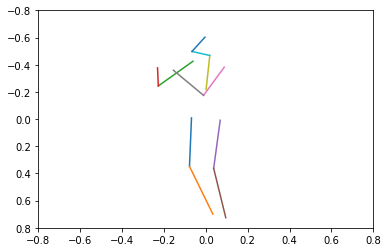

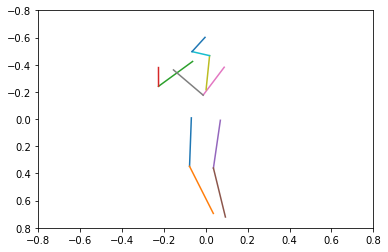

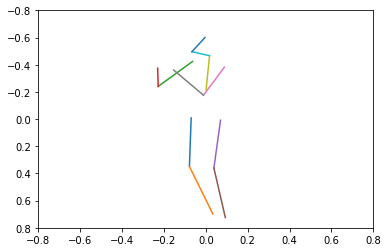

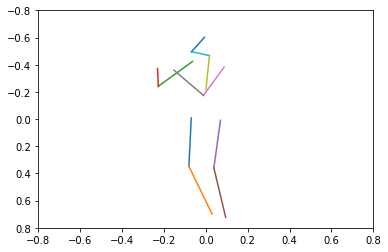

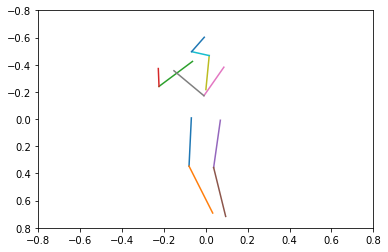

In [11]:
edges = [(1,2), (2,3), (14, 15), (15, 16), (4, 5), (5, 6), (11, 12), (12, 13), (7, 8), (8, 9), (9, 10)]
predicted_3d_pos = predicted_3d_pos.cpu().numpy()
for k in range(50, 55):
    plt.xlim(-0.8, 0.8)
    plt.ylim(0.8, -0.8)
    for i, j in edges:
        plt.plot(predicted_3d_pos[0, k, [i, j], 0], predicted_3d_pos[0, k, [i, j], 1])
    plt.show()